In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 1. Data Understanding

In [3]:
data=pd.read_csv("day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#Dropping columns :
#instant-not needed as index is not useful
#dteday - already days,year and month is covered in other features
#casual,registered - since casual and registered cannot predict total count,they are just a biforcation of target variable
data.drop(["instant","dteday","casual","registered"],axis=1,inplace=True)

In [5]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


## 2. Exploratory Data Analysis

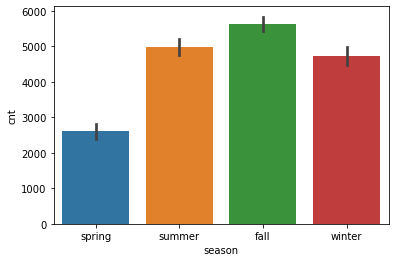

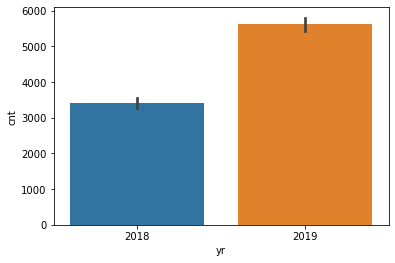

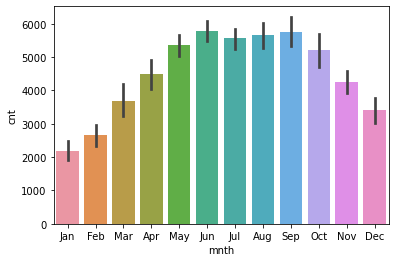

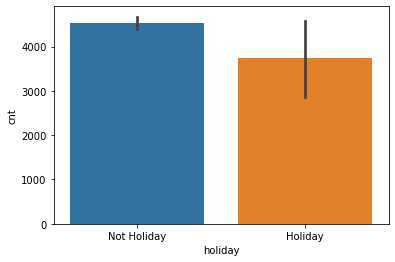

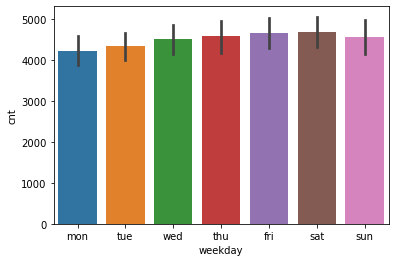

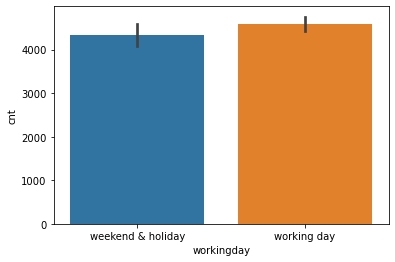

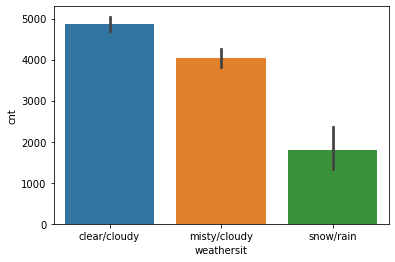

In [6]:
#Understanding categorical data with target variable
cat_features=["season","yr","mnth","holiday","weekday","workingday","weathersit"]
#Dictionary for x axis labels
cat_features_dict={"season":["spring","summer","fall","winter"],"yr":["2018","2019"],"mnth":["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"holiday":["Not Holiday","Holiday"]
,"weekday":["mon","tue","wed","thu","fri","sat","sun"],"workingday":["weekend & holiday","working day"],"weathersit":["clear/cloudy","misty/cloudy","snow/rain"]}
for feature in cat_features:
    ax=sns.barplot(data=data,y='cnt',x=feature)
    ax.set_xticklabels(cat_features_dict[feature])
    plt.show()

### Insights
-There are low customers sharing bikes during spring season<br>
-There are higher customers(nearly doubled) sharing bikes in 2019 as compared to 2018<br>
-People share bikes lesser in holidays as compared to non-holidays<br>
-People have taken more bikes in clear and cloudy weather as compared to other weather conditions<br>
-There is no significant effect of weekday or working day on the count of customers sharing the bikes<br><br>
`This helps us understand what might the important features to consider for linear regression based on the data`

In [7]:
#Describing numeric features in your dataset
numeric_features=["temp","atemp","hum","windspeed","cnt"]

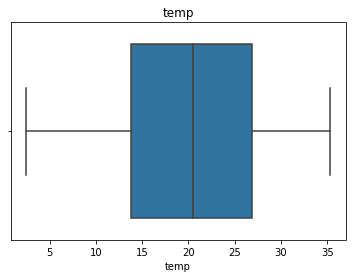

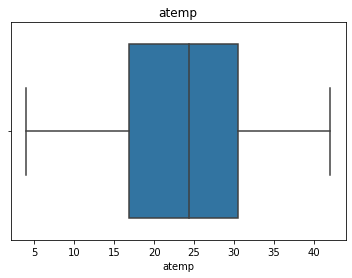

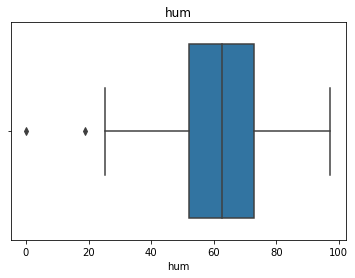

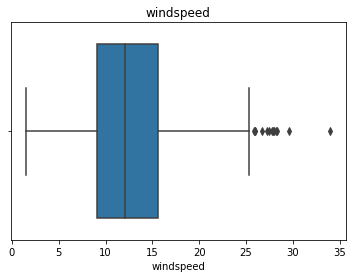

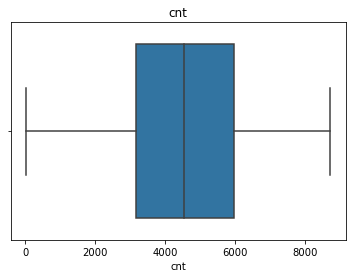

In [8]:
#Understanding the numeric data
#Checking box plot
for feature in numeric_features:
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.show()

### Insights
- There are some outliers in input variables(humidity and windspeed)<br>
- There are no outliers in the target variable(cnt)<br>

`However we cannot remove outliers based on only input data, we have to check its effect on target variable and remove the outliers`

In [9]:
import plotly.express as px
for feature in numeric_features:
    if feature!="cnt":
        fig = px.scatter(data, x=feature, y="cnt")
        fig.show()


Outlier Detection - From the scatter plots, some points were out of trend, for fitting Linear regression model, its important to clean the data and remove extreme points(outliers)

In [10]:
#List of tuplies (feature value, target value)
outlier_temp=[(25.99043,1842),(27.88,1115),(18.04,22),(35.328347,4840)]
outlier_atemp=[(12.12,7148),(21.97,22),(31.7778,1115),(42.0448,3387),(41.31855,3784)]
outlier_hum=[(0,623),(18.7917,1635)]
outlier_windspeed=[(1.5002439,4985),(34.000021,1635),(29.584721,5382)]
outlier_dict={"temp":outlier_temp,"atemp":outlier_atemp,"hum":outlier_hum,"windspeed":outlier_windspeed}

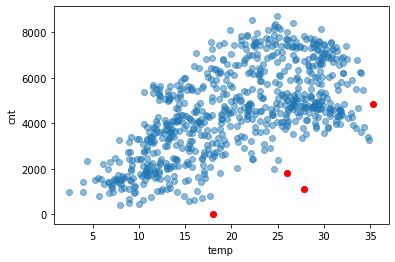

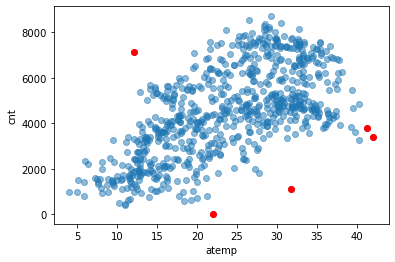

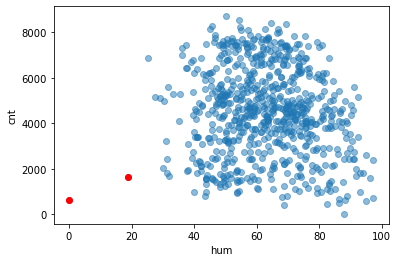

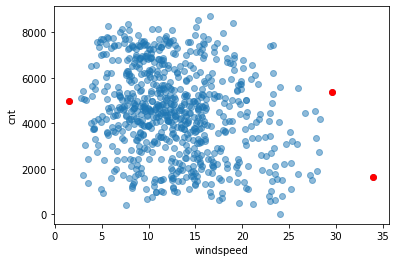

In [11]:
#Highlighting outliers
for feature in numeric_features:
    if feature!="cnt":
        plt.scatter(data[feature],data["cnt"],alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel("cnt")
        out_pnts=outlier_dict[feature]
        for xy in out_pnts:
            plt.scatter(xy[0],xy[1],color="red")
        plt.show()


`All the numeric features show linearity with the target variable, it is good to use multi linear regression for this problem`

### 3. Data Preparation

In [12]:
#We can find some outliers in windspeed and humidity,capping those variables to maximum bounds
def remove_outliers(df,feature,odict):
    tup=odict[feature]
    for t in tup:        
        df=df[~((df[feature] == t[0]) & (df["cnt"] == t[1]))]
    print(f"Outliers removed in {feature}")
    return df
init_len=len(data)

data=remove_outliers(data,"temp",outlier_dict)
data=remove_outliers(data,"atemp",outlier_dict)
data=remove_outliers(data,"hum",outlier_dict)
data=remove_outliers(data,"windspeed",outlier_dict)
#Total outliers removed
fin_len=len(data)
rem=init_len-fin_len
print(f"Totally {rem} outliers removed from data")

Outliers removed in temp
Outliers removed in atemp
Outliers removed in hum
Outliers removed in windspeed
Totally 10 outliers removed from data


In [13]:
#Dummy encoding weathersit variable
#Combinations : 
#10 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#01 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#00 - Clear, Few clouds, Partly cloudy, Partly cloudy
# Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog -- Absent in data
weather_status=pd.get_dummies(data["weathersit"],drop_first=True)
weather_status.rename(columns={2:"misty",3:"light rain/snow"},inplace=True)
data=pd.concat([data,weather_status],axis=1)
data.drop("weathersit",axis=1,inplace=True)

In [14]:
#Dummy encoding seasons variable
#000-spring
#100-summer
#010-fall
#001-winter
seasons=pd.get_dummies(data["season"],drop_first=True)
seasons.rename(columns={2:"summer",3:"fall",4:"winter"},inplace=True)
data=pd.concat([data,seasons],axis=1)
data.drop("season",axis=1,inplace=True)

In [15]:
#Dataframe after encoding
data.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,misty,light rain/snow,summer,fall,winter
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0


In [16]:
from sklearn.model_selection import train_test_split

# Splitting into train and test dataframes
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 0)

In [17]:
df_train[numeric_features].describe()

,temp,atemp,hum,windspeed,cnt
count,503.000000,503.000000,503.000000,503.000000,503.000000
mean,20.229678,23.643633,62.527768,12.714344,4526.880716
std,7.544800,8.183477,14.181348,5.166420,1879.797920
min,3.957390,4.941955,25.416700,2.834381,431.000000
25%,13.940000,16.918125,50.833350,8.895791,3241.000000
50%,20.055847,23.925600,62.916700,12.291418,4548.000000
75%,26.957500,30.587700,72.895800,15.616829,5893.500000
max,34.815847,40.214350,97.250000,28.292425,8555.000000


In [18]:
df_test[numeric_features].describe()

,temp,atemp,hum,windspeed,cnt
count,216.000000,216.000000,216.000000,216.000000,216.000000
mean,20.327282,23.753409,63.718296,12.671080,4517.666667
std,7.361700,7.950863,13.495282,4.818376,2038.166858
min,2.424346,3.953480,31.416700,3.042356,683.000000
25%,13.615413,16.287500,53.708350,9.343904,2882.000000
50%,20.944173,24.888975,62.233700,11.792000,4562.500000
75%,26.615847,30.193375,73.395825,15.437772,6185.250000
max,34.030000,39.741450,96.250000,27.292182,8714.000000


#### Insights : It can be seen that df_train and df_test don't have significant differences in the mean and median values of features and predictors, hence its `randomly split` and `not biased`

<Figure size 1080x720 with 0 Axes>

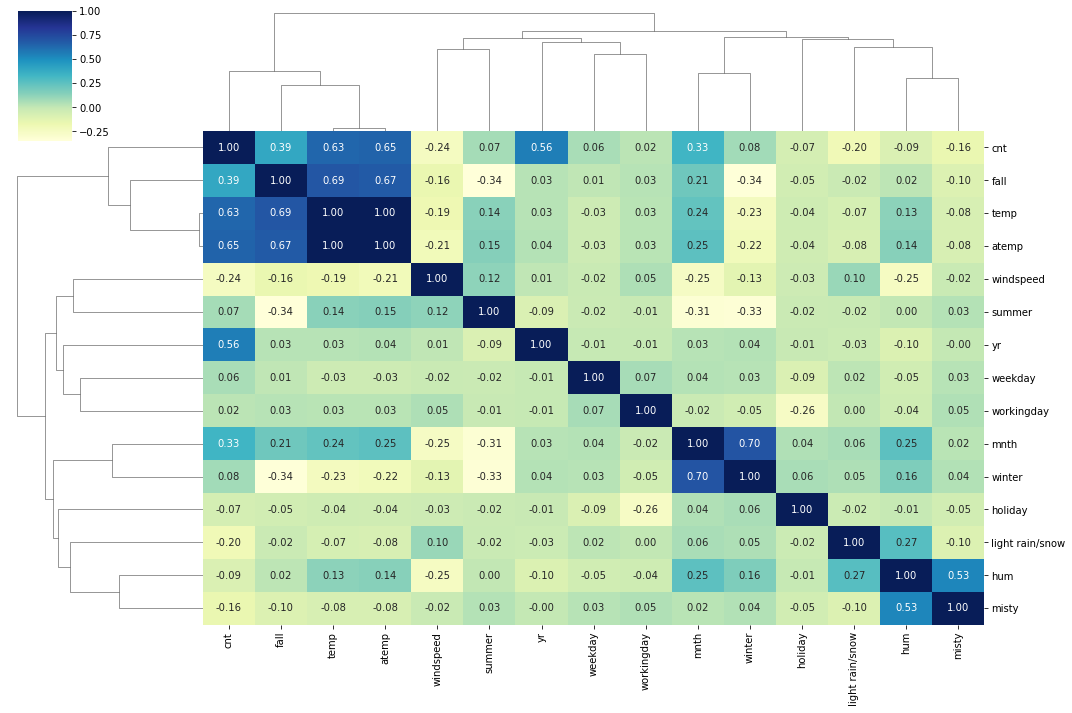

In [19]:
#Correlation Map
plt.figure(figsize=(15,10))
# sns.heatmap(df_train.corr(),annot=True,cmap="YlGnBu",fmt=".2f")
sns.clustermap(df_train.corr(), figsize=(15, 10),annot=True,cmap="YlGnBu",fmt=".2f")

### Insights
-Target variable cnt is highly correlated with atemp,yr,fall season, its also correlating with mnth,windspeed & weather(light rain/snow,misty)<br><br> - These can be starting features for linear regression model<br>
- atemp and temp are fully correlated, dropping temp since atemp has higher correlation with target variable<br>
- mnth and winter, hum and misty, are highly correlated

In [20]:
#Dropping temp feature since its correlated with atemp very highly and follows a linear relation
#It will lead to multicolinearity in the model hence dropping it from data
#Actual temperature would be more relevant and has more correlation to target variable
df_train.drop("temp",axis=1,inplace=True)
df_test.drop("temp",axis=1,inplace=True)
data.drop("temp",axis=1,inplace=True)
numeric_features.remove("temp")

In [21]:
#Scaling Numeric features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#Training Set
df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])
# #Test Set
df_test[numeric_features] = scaler.transform(df_test[numeric_features])

In [22]:
#Dividing into X & y sets for test and train
#Train
y_train = df_train.pop('cnt')
X_train = df_train
#Test
y_test = df_test.pop('cnt')
X_test = df_test

### 4. Building Linear Regression Model
Following a bottoms up approach to keep adding on predictors, starting with atemp which is the most correlated variable with target variable

In [23]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Function for linear regression for each set of features
def linear_regression_feature(X_tr,y_tr,features,vif_flag=1):
    #1. Train the model
    X_train_sm = sm.add_constant(X_tr[features])
    lr = sm.OLS(y_tr, X_train_sm).fit()
    print(lr.summary())

    #2. Checking multi-collinearity : VIF
    #If VIF flag is not zero, then only calculate VIF, by default it vif_flag=1
    if vif_flag!=0:
        # VIF
        vif = pd.DataFrame()
        features=X_tr[features]
        vif['Features'] = features.columns
        vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        print(vif)
    
    # #3. Visualizing the spread of model prediction vs actual data
    # y_pred_train=lr.predict(X_train_sm)
    # plt.scatter(y_pred_train, y_tr)
    # plt.xlabel("Predicted")
    # plt.ylabel("Actual")
    # plt.show()
    return lr

#### **Feature 1** : `atemp`

In [24]:
#Keep adding required features in bottoms-up approach
feature_req=['atemp']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=0)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     362.5
Date:                Tue, 03 May 2022   Prob (F-statistic):           3.30e-61
Time:                        14:34:28   Log-Likelihood:                 159.90
No. Observations:                 503   AIC:                            -315.8
Df Residuals:                     501   BIC:                            -307.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1616      0.020      8.226      0.0

## Rsquared_1= `0.420`

#### **Feature 2** : `yr`
Since we can see the demand of bikes going up in 2019 as compared to 2018

In [25]:
feature_req=['atemp','yr']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     601.9
Date:                Tue, 03 May 2022   Prob (F-statistic):          7.71e-134
Time:                        14:34:28   Log-Likelihood:                 331.34
No. Observations:                 503   AIC:                            -656.7
Df Residuals:                     500   BIC:                            -644.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0474      0.015      3.180      0.0

## Rsquared_2 = `0.707`

#### **Feature 3** : `misty`,`light rain/snow`
Its logical that the weather can affect the demand of bike sharing


In [38]:
X_train.columns

yr
mnth
holiday
weekday
workingday
atemp
hum
windspeed
misty
light rain/snow
summer
fall
winter


In [27]:
#Adding weather features
feature_req=['atemp','yr','misty','light rain/snow']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     357.1
Date:                Tue, 03 May 2022   Prob (F-statistic):          9.72e-145
Time:                        14:34:28   Log-Likelihood:                 363.20
No. Observations:                 503   AIC:                            -716.4
Df Residuals:                     498   BIC:                            -695.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0869      0.015     

## Rsquared_3 = `0.741`

#### **Feature 4** : `summer`,`fall`,`winter`
Season can affect the demand for the bikes

In [28]:
#Adding season features
feature_req=['atemp','yr','misty','light rain/snow','summer','fall','winter']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     290.9
Date:                Tue, 03 May 2022   Prob (F-statistic):          6.72e-171
Time:                        14:34:31   Log-Likelihood:                 433.41
No. Observations:                 503   AIC:                            -850.8
Df Residuals:                     495   BIC:                            -817.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0424      0.015     

Dropping feature : <br>
Here we can see VIF of atemp is 11.32, it shows it is multicollinear with one of the seasons, in correlation we had seen atemp and fall having high correlation, hence `dropping fall` season feature

## Rsquared_4 = `0.804`

In [30]:
#Dropping fall feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     320.4
Date:                Tue, 03 May 2022   Prob (F-statistic):          4.44e-167
Time:                        14:37:19   Log-Likelihood:                 421.47
No. Observations:                 503   AIC:                            -828.9
Df Residuals:                     496   BIC:                            -799.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0236      0.015     

Inference : We can see that after dropping fall, the multicollinearity in atemp is removed

## Rsquared_4_corrected = `0.795`

#### **Feature 5** : `mnth`
Month of the year can affect the demand for the bikes

In [33]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [35]:
#Adding mnth features
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','mnth']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     278.2
Date:                Tue, 03 May 2022   Prob (F-statistic):          4.67e-167
Time:                        14:40:38   Log-Likelihood:                 424.40
No. Observations:                 503   AIC:                            -832.8
Df Residuals:                     495   BIC:                            -799.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0133      0.015     

Adding month variable increases the collinearity amongst other features and has no significant improvement in Rsquare value, hence `dropping mnth`

## Rsquared_5 = `0.797`

#### **Feature 5b** : `windspeed`
Windspeed may be preferrable for some customers

In [36]:
#Adding windspeed feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     286.1
Date:                Tue, 03 May 2022   Prob (F-statistic):          1.81e-169
Time:                        14:45:23   Log-Likelihood:                 430.06
No. Observations:                 503   AIC:                            -844.1
Df Residuals:                     495   BIC:                            -810.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0740      0.019     

## Rsquared_5_corrected = `0.802`

#### **Feature 6** : `hum`
Humidity may be preferrable for some customers

In [39]:
#Adding humidity feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','hum']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     266.9
Date:                Tue, 03 May 2022   Prob (F-statistic):          6.12e-174
Time:                        14:50:44   Log-Likelihood:                 443.50
No. Observations:                 503   AIC:                            -869.0
Df Residuals:                     494   BIC:                            -831.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1439      0.023     

Inference : Adding humidity adds multicollinearity, dropping `hum`

#### **Feature 7** : `holiday`
 holidays may be a predictor for demand of bikes

In [58]:
#Adding humidity feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     255.8
Date:                Tue, 03 May 2022   Prob (F-statistic):          2.84e-170
Time:                        15:05:46   Log-Likelihood:                 434.87
No. Observations:                 503   AIC:                            -851.7
Df Residuals:                     494   BIC:                            -813.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0793      0.019     

## Rsquared_7 = `0.806`

#### **Feature 8** : `weekday`
 weekday may be a predictor for demand of bikes

In [59]:
#Adding humidity feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday','weekday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     236.4
Date:                Tue, 03 May 2022   Prob (F-statistic):          1.37e-172
Time:                        15:07:30   Log-Likelihood:                 443.21
No. Observations:                 503   AIC:                            -866.4
Df Residuals:                     493   BIC:                            -824.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0498      0.020     

## Rsquared_8 = `0.812`

#### **Feature 8** : `workingday`
 working may be a predictor for demand of bikes

In [60]:
#Adding workingday feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday','weekday','workingday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     212.6
Date:                Tue, 03 May 2022   Prob (F-statistic):          1.70e-171
Time:                        15:08:51   Log-Likelihood:                 443.46
No. Observations:                 503   AIC:                            -864.9
Df Residuals:                     492   BIC:                            -818.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0455      0.021     

Inference : The working day feature has a Pvalue of 0.484 which means it is not a significant feature and logically its a combination of holiday and weekday, hence dropping `workingday`

In [62]:
#Adding workingday feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday','weekday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     236.4
Date:                Tue, 03 May 2022   Prob (F-statistic):          1.37e-172
Time:                        15:11:04   Log-Likelihood:                 443.21
No. Observations:                 503   AIC:                            -866.4
Df Residuals:                     493   BIC:                            -824.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0498      0.020     

## Conclusion of Model Training
Hence all the features were tried and some of them were dropped because they were multi-collinear(`mnth`,`hum`,`fall`), some were having high P value(`workingday`),<br> hence final model has features with P-value<0.05 and VIF<5 

### Final_Model_Rsquared = `0.812`

In [ ]:
sns.distplot(res,bins=50)

5. Evaluation on Test Data

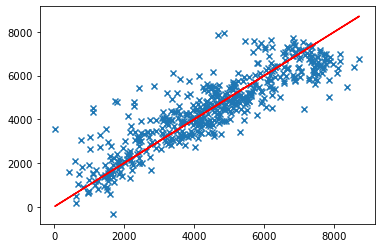

In [184]:
plt.scatter(y_train, ypred,marker='x')
plt.plot(y_train,y_train, 'r')
plt.show()

In [192]:
from scipy.stats import shapiro
import random
from numpy.random import randn
data1 = randn(1000)+pow(2,randn(1000))
stat, p = shapiro(data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.948, p=0.000
Sample does not look Gaussian (reject H0)


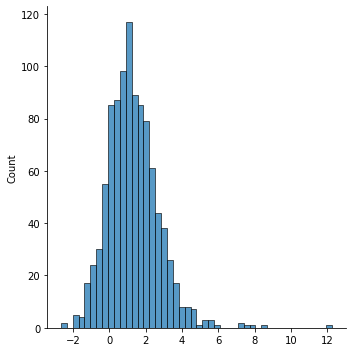

In [193]:
sns.displot(data1)

In [187]:
data

-1.7344058724925462

In [190]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.992, p=0.822
Sample looks Gaussian (fail to reject H0)
